<a href="https://colab.research.google.com/github/joyang15/MSCI-446-Project-Winter-2022/blob/main/MSCI_446_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports + Cleaning

In [ ]:
from os import sched_rr_get_interval
import numpy as np
import pandas as pd
from sklearn import decomposition
from scipy import linalg
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression

# read TEDtalk.csv in to a dataframe
data = pd.read_csv('sample_data/TEDtalk.csv', engine = 'python', encoding='utf-8', error_bad_lines=False, warn_bad_lines=False)

# removes categories with '#N/A'
data = data.dropna(subset = ["transcript"])
data = data[ data['category'].str.contains("#N/A")==False ] 

# a dictionary that relates category names to a numner
dictionary_cat_num = {'Health/Science':0,'Arts/Music/Entertainment':1, 'Technology':2, 
                      'Earth/Environment/Ecosystem':3, 'Politics':4, 'World':5,
                      'Emotions/Behaviour/Humanity':6, 'Family/Life':7, 'Career':8,
                      'Education':9, 'Identity':10, 'Media':11,
                      'Business':12, 'Religion':13, 'Law/Crime':14,
                      'Charity Efforts/Activism':15, 'Travel':16, 'Animals/Aliens':17,
                      'Food':18,'TED':19, 'History':20,
                      'Safety Concerns':21}
data['category_number'] = data.category.map(dictionary_cat_num) #mapping words to numbers

# transcript data frame
transcript = data['transcript'].to_frame()
# category data frame
category = data['category_number'].to_frame()
# category_num data frame
category_num = data['category_number'].to_frame()
category_num.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,category_number
0,3
1,2
2,4
3,2
4,2


# Data Exploration

In [ ]:
data.head(5)

,id,speaker,headline,URL,description,transcript_URL,month_filmed,year_filmed,event,duration,...,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general,category_number
0,1.0,Al Gore,Averting the climate crisis,http://www.ted.com/talks/view/id/1,With the same humor and humanity he exuded in ...,http://www.ted.com/talks/view/id/1/transcript?...,2.0,2006.0,TED2006,0:16:17,...,0.00,0.00,0.48,0.00,0.22,0.0,0.00,0.00,0.22,3
1,2.0,Amy Smith,Simple designs to save a life,http://www.ted.com/talks/view/id/2,Fumes from indoor cooking fires kill more than...,http://www.ted.com/talks/view/id/2/transcript?...,2.0,2006.0,TED2006,0:15:06,...,0.00,0.00,0.30,0.00,0.11,0.0,0.11,0.04,0.15,2
2,3.0,Ashraf Ghani,How to rebuild a broken state,http://www.ted.com/talks/view/id/3,Ashraf Ghani's passionate and powerful 10-minu...,http://www.ted.com/talks/view/id/3/transcript?...,7.0,2005.0,TEDGlobal 2005,0:18:45,...,0.16,0.04,0.32,0.12,0.20,0.0,0.04,0.04,0.08,4
3,4.0,Burt Rutan,The real future of space exploration,http://www.ted.com/talks/view/id/4,"In this passionate talk, legendary spacecraft ...",http://www.ted.com/talks/view/id/4/transcript?...,2.0,2006.0,TED2006,0:19:37,...,0.00,0.00,0.19,0.00,0.10,0.0,0.00,0.00,0.16,2
4,5.0,Chris Bangle,Great cars are great art,http://www.ted.com/talks/view/id/5,American designer Chris Bangle explains his ph...,http://www.ted.com/talks/view/id/5/transcript?...,2.0,2002.0,TED2002,0:20:04,...,0.03,0.00,0.39,0.00,0.05,0.0,0.00,0.03,0.13,2


In [ ]:
data.shape #show rows and columns

(2032, 125)

In [ ]:
data.ndim

2

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2032 entries, 0 to 2474
Columns: 125 entries, id to category_number
dtypes: float64(112), int64(1), object(12)
memory usage: 2.0+ MB


In [ ]:
data.describe() #Get the statistics of the dataset

,id,month_filmed,year_filmed,views_as_of_06162017,WC,Analytic,Clout,Authentic,Tone,WPS,...,fairness_virtue,fairness_vice,ingroup_virtue,ingroup_vice,authority_virtue,authority_vice,purity_virtue,purity_vice,morality_general,category_number
count,2032.000000,2032.000000,2032.000000,2.032000e+03,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,...,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000,2032.000000
mean,1435.955709,5.461122,2011.337106,1.684031e+06,2145.973425,55.671954,74.015974,38.857638,53.045448,17.090645,...,0.040827,0.014508,0.235069,0.041890,0.200669,0.012569,0.033932,0.054626,0.226063,3.245079
std,835.818326,3.420399,3.675279,2.486568e+06,981.940822,17.053675,13.070196,17.321050,20.046764,8.500551,...,0.082346,0.063918,0.244574,0.099729,0.233660,0.040405,0.073783,0.154324,0.232804,4.121251
min,1.000000,1.000000,1984.000000,1.389150e+05,6.000000,3.150000,1.000000,1.000000,1.000000,5.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,700.750000,2.000000,2009.000000,7.537535e+05,1414.500000,43.627500,67.270000,25.807500,39.832500,14.270000,...,0.000000,0.000000,0.070000,0.000000,0.060000,0.000000,0.000000,0.000000,0.080000,0.000000
50%,1467.500000,4.000000,2012.000000,1.117335e+06,2165.500000,55.705000,76.400000,37.120000,52.935000,16.385000,...,0.000000,0.000000,0.170000,0.000000,0.145000,0.000000,0.000000,0.000000,0.180000,2.000000
75%,2197.250000,8.000000,2014.000000,1.684936e+06,2828.000000,67.832500,83.032500,49.945000,66.817500,18.780000,...,0.050000,0.000000,0.310000,0.050000,0.260000,0.000000,0.040000,0.050000,0.300000,4.000000
max,2804.000000,12.000000,2017.000000,4.562291e+07,6088.000000,98.180000,99.000000,94.590000,99.000000,257.000000,...,0.970000,1.220000,1.750000,1.290000,2.950000,0.570000,0.710000,2.700000,3.520000,21.000000


In [ ]:
data['category'].value_counts()

Health/Science                 543
Arts/Music/Entertainment       424
Technology                     293
Earth/Environment/Ecosystem    135
Politics                       132
World                          103
Emotions/Behaviour/Humanity     65
Family/Life                     55
Career                          44
Education                       42
Identity                        40
Media                           30
Business                        23
Religion                        21
Law/Crime                       19
Charity Efforts/Activism        13
Travel                          13
Animals/Aliens                  13
Food                             7
TED                              7
History                          7
Safety Concerns                  3
Name: category, dtype: int64

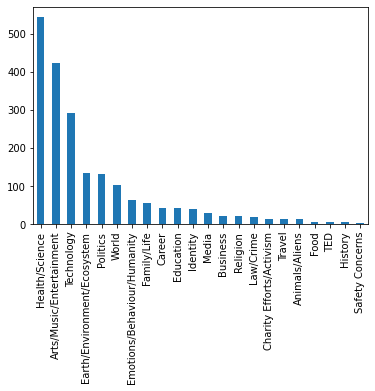

In [ ]:
#plots the number of TED Talks in each category
data['category'].value_counts().plot(kind='bar')

# Text Mining

#### Methods

In [ ]:
from sklearn.feature_extraction import _stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

#from nltk.tokenize import word_tokenize

import re,string

# function that takes a string, 
# turns it into lower case and removes stopwords and punctuation
def clean_text(text):
  # turn text into lowercase
  text = text.lower()

  # remove stopwords
  text = ' '.join([word for word in text.split() if word not in stop_words])
  
  # remove punctuation (found at string.punctuation)
  text = ''.join([word for word in text if word not in string.punctuation])
  text = ' '.join([word for word in text.split() if word != 'im' and word != 'like' and word != 'likes' and word != 'it' and word != 'its' and word != 'really'])
  
  # return the clean text
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# method to remove numbers from text
# code adapted from: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
def remove_numbers(text):
    
    removed_numbers = re.sub('[0-9]+', '', text)
    return removed_numbers

In [ ]:
# initialize a letammatizer (to reduce words to their roots)
wn = nltk.WordNetLemmatizer()
nltk.download('wordnet') # have to run once
nltk.download('omw-1.4') # have to run once
nltk.download('punkt') # for tokenize
nltk.download('averaged_perceptron_tagger') # for POS tag

# function that takes a string,
# splits it into inidivual words and stems each one of them,
# return the array as a string to be saved in the dataframe
stemmer = SnowballStemmer("english")
def stemming(text):
  text = [stemmer.stem(word) for word in text.split()]
  return str(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#### Apply data cleaning

In [ ]:
# add a 'no_numbers' column to remove numbers in the transcript (*limitation: does exclude all numbers, not just timestamp)
transcript['no_numbers'] = transcript['transcript'].apply(lambda x: remove_numbers(str(x)))

# add a 'non_stop' column to the dataframe that stores the clean version of every post
transcript['non_stop'] = transcript['no_numbers'].apply(lambda x: clean_text(str(x))) # had to get rid of .strip() because was giving error (x.strip())

# stemming of words
transcript['stem']  = transcript['non_stop'].apply(lambda x: stemming(x))

In [ ]:
# show the first 5 rows
transcript.head()

,transcript,no_numbers,non_stop,stem
0,"0:14\n\n\nThank you so much, Chris.\nAnd it's ...",":\n\n\nThank you so much, Chris.\nAnd it's tru...",thank much chris truly great honor opportunity...,"['thank', 'much', 'chris', 'truli', 'great', '..."
1,"0:11\n\n\nIn terms of invention,\nI'd like to ...",":\n\n\nIn terms of invention,\nI'd like to tel...",terms invention id tell tale one favorite proj...,"['term', 'invent', 'id', 'tell', 'tale', 'one'..."
2,"0:12\n\n\nA public, Dewey long ago observed,\n...",":\n\n\nA public, Dewey long ago observed,\nis ...",public dewey long ago observed constituted dis...,"['public', 'dewey', 'long', 'ago', 'observ', '..."
3,"0:11\n\n\nI want to start off by saying, Houst...",":\n\n\nI want to start off by saying, Houston,...",want start saying houston problem were enterin...,"['want', 'start', 'say', 'houston', 'problem',..."
4,"0:12\n\n\nWhat I want to talk about is, as bac...",":\n\n\nWhat I want to talk about is, as backgr...",want talk is background idea cars art actually...,"['want', 'talk', 'is', 'background', 'idea', '..."


#### TFIDF

In [ ]:
# TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer

# initialize a tf-idf vectorizer with english stop words, with a maximum amount of features
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_features = 2000)
# initialize a tf-idf vectorizer to instill 1+log(tf)
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)


## fit and transform the lemmatized words through the vectorizer
# this will give the numbers inside the matrix
vectors_tfidf = vectorizer_tfidf.fit_transform(transcript['stem']) 
# put this as columns in pandas dataframe
feature_names = vectorizer_tfidf.get_feature_names_out()

# to add the TFIDF into a data frame
dense = vectors_tfidf.todense()
denselist = dense.tolist()
tfidf_df = pd.DataFrame(denselist, columns = feature_names)

In [ ]:
tfidf_df

,abil,abl,absolut,abstract,abus,academ,acceler,accept,access,accid,...,yearold,yellow,yes,yesterday,york,young,younger,zero,zone,zoom
0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.020175,0.034469,0.000000,0.020146,0.000000,0.000000,0.0,0.0
1,0.017582,0.023171,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.018142,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.017473,0.046053,0.05251,0.0,0.0,0.000000,0.000000,0.020937,0.018029,0.0,...,0.000000,0.0,0.015240,0.000000,0.000000,0.000000,0.000000,0.045442,0.0,0.0
3,0.014483,0.019087,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.054106,0.0,0.000000,0.000000,0.000000,0.025228,0.000000,0.000000,0.0,0.0
4,0.000000,0.008667,0.00000,0.0,0.0,0.000000,0.000000,0.031524,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.014193,0.011456,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,0.043560,0.014351,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.027122,0.0,0.000000,0.000000,0.094000,0.000000,0.000000,0.000000,0.0,0.0
2028,0.047724,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2029,0.000000,0.016566,0.00000,0.0,0.0,0.039428,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.021929,0.000000,0.000000,0.021897,0.040178,0.000000,0.0,0.0
2030,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.041852,0.000000,0.000000,0.0,0.0


####Count Vectorizer

In [ ]:
# count vectorizer

from sklearn.feature_extraction.text import CountVectorizer
# initialize a count vectorizer with english stop words, with a maximum amount of features
vectorizer_count = CountVectorizer(stop_words='english', max_features = 2000)

## fit and transform the lemmatized words through the vectorizer
# this will give the numbers inside the matrix
vectors_count = vectorizer_count.fit_transform(transcript['stem'])

# put this as columns in pandas dataframe
feature_names_count_vec = vectorizer_count.get_feature_names_out() 

# to add the count vectorizer into a data frame
dense_c = vectors_count.todense()
denselist_c = dense_c.tolist()
count_df = pd.DataFrame(denselist_c, columns = feature_names)

In [ ]:
 count_df

,abil,abl,absolut,abstract,abus,academ,acceler,accept,access,accid,...,yearold,yellow,yes,yesterday,york,young,younger,zero,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,0
1,1,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,3,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,2,0,0
3,1,2,0,0,0,0,0,0,0,0,...,3,0,0,0,0,2,0,0,0,0
4,0,1,0,0,0,0,0,2,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,2,1,0,0,0,0,0,0,0,0,...,1,0,0,0,4,0,0,0,0,0
2028,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2029,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
2030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0


# Supervised Learning

In [ ]:
# created a new dataframe that's just the stemmed transcript and category number
df_s = data['category_number'].to_frame()
extracted_col = transcript['stem']
df_s = df_s.join(extracted_col)
df_s.head(5)

,category_number,stem
0,3,"['thank', 'much', 'chris', 'truli', 'great', '..."
1,2,"['term', 'invent', 'id', 'tell', 'tale', 'one'..."
2,4,"['public', 'dewey', 'long', 'ago', 'observ', '..."
3,2,"['want', 'start', 'say', 'houston', 'problem',..."
4,2,"['want', 'talk', 'is', 'background', 'idea', '..."


#### Logistic Regression

###### Experiment 1: Logistic Regression with TFIDF

In [ ]:
# For logistic regression model training
# X is a dataframe with only features, which in this case comes from the TFIDF
X = tfidf_df

# Y is the categories, which is the target
Y = data['category_number']
Y = np.ravel(Y)
log_model = LogisticRegression()
log_model.fit(X,Y)

# this gets the accuracy score of training model
log_model.score(X,Y)

0.7460629921259843

In [ ]:
# this gets the coefficients of the logistic training model
coeff_df1 = pd.DataFrame(zip(X.columns,np.transpose(log_model.coef_)))
coeff_df1

,0,1
0,abil,"[0.47847081441755634, -0.36961317863365356, 0...."
1,abl,"[0.5546472506897743, -0.2465262699781882, 0.37..."
2,absolut,"[0.1673514074334374, -0.22025224043724342, 0.0..."
3,abstract,"[0.1156565560334192, 0.3302870342697425, -0.08..."
4,abus,"[0.12356118166669344, -0.3888489390663923, -0...."
...,...,...
1995,young,"[-0.6762829392811585, -0.32435893154772555, -0..."
1996,younger,"[0.0106136487642137, -0.2095171312509814, -0.0..."
1997,zero,"[-0.23163846672139873, -0.05568936916544539, 0..."
1998,zone,"[-0.26241791860504654, -0.3454228937860331, -0..."


In [ ]:
# This part is to create a new logistic regression model by splitting training and testing sets
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 0)

# Make a new logistic regression model
log_model2 = LogisticRegression()

# Fit the new logistic regression model
log_model2.fit(X_train,Y_train)

LogisticRegression()

In [ ]:
# This part is to use the testing data to see what the model predicts

# class_predict is the predicted values by the model
class_predict = log_model2.predict(X_test)


# Y_test is the actual data, class_predict is the predicted values by the model
metrics.accuracy_score(Y_test,class_predict)

0.6519607843137255

In [ ]:
# this gets the coefficients of the new logistic regression model
coeff_df2 = pd.DataFrame(zip(X.columns,np.transpose(log_model2.coef_)))
coeff_df2

,0,1
0,abil,"[0.48016909028472643, -0.4079629191433649, 0.1..."
1,abl,"[0.5145408612424608, -0.28925214076920225, 0.3..."
2,absolut,"[0.1371822786361342, -0.16271277858159464, 0.0..."
3,abstract,"[0.06437521483825241, 0.3119755379581091, -0.0..."
4,abus,"[0.08324514132977337, -0.3659179128276541, -0...."
...,...,...
1995,young,"[-0.6581022139034516, -0.27378656812015284, -0..."
1996,younger,"[0.03418232794601736, -0.20871571769684577, -0..."
1997,zero,"[-0.298235227940038, -0.04616823786678828, 0.3..."
1998,zone,"[-0.22461297406652728, -0.3408855700060675, -0..."


In [ ]:
# This part evaluates the model with confusion matrix and accuracy score
print(confusion_matrix(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print(accuracy_score(Y_test, class_predict))

[[51  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7 38  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  5 23  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  1  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  8  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  2  0  2  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 1  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


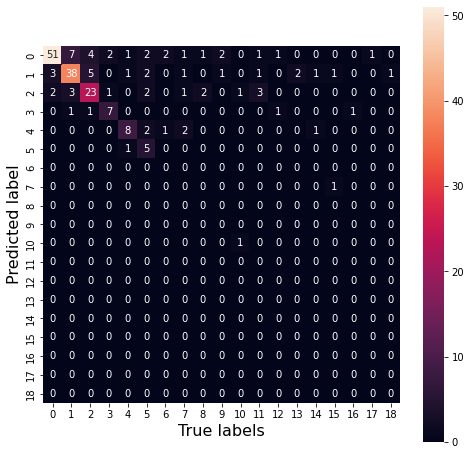

The accuracy is 0.6519607843137255


In [ ]:
# Code adapted from: https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a#:~:text=1.-,Introduction,is%20independent%20of%20each%20other.
# This part plots the confusion matrix on a heat map
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(Y_test,class_predict)

# Create heat map with seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True labels", fontdict={"fontsize": 16})
plt.ylabel("Predicted label", fontdict={"fontsize": 16})

# Show the map
plt.show()
print("The accuracy is {}".format(accuracy_score(Y_test,class_predict)))

###### Experiment 2: Logistic Regression with Count Vectorizer

In [ ]:
# For logistic regression model training
# Xc is a dataframe with only features, which in this case comes from the count vectorizer
Xc = count_df

# Y is the categories, which is the target
Yc = data['category_number']
Yc = np.ravel(Yc)
log_model_c = LogisticRegression(max_iter=1000)
log_model_c.fit(Xc,Yc)

# this gets the accuracy score of training model
log_model_c.score(Xc,Yc)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


1.0

In [ ]:
# This part is to create a new logistic regression model by splitting training and testing sets
# Split the data
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(Xc,Yc, test_size = 0.1, random_state = 0)

# Make a new logistic regression model
log_model_c2 = LogisticRegression(max_iter = 1000)

# Fit the new logistic regression model
log_model_c2.fit(X_train_c,Y_train_c)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=1000)

In [ ]:
# This part is to use the testing data to see what the model predicts

# class_predict is the predicted values by the model
class_predict_c = log_model2.predict(X_test_c)


# Y_test_c is the actual data, class_predict_c is the predicted values by the model
metrics.accuracy_score(Y_test_c,class_predict_c)

0.5294117647058824

In [ ]:
# this gets the coefficients of the new logistic regression model
coeff_df2_c = pd.DataFrame(zip(Xc.columns,np.transpose(log_model_c2.coef_)))
coeff_df2_c

,0,1
0,abil,"[0.10152296549989138, -0.1736971391806767, 0.0..."
1,abl,"[0.14817612330209817, -0.06376834341062015, 0...."
2,absolut,"[-0.0006693251156692111, -0.057222722360172375..."
3,abstract,"[-0.003450586237534945, 0.07755138074890788, -..."
4,abus,"[0.0713249201857218, -0.071614537614163, -0.01..."
...,...,...
1995,young,"[-0.08841036995055403, -0.02058322394799285, -..."
1996,younger,"[0.015937937819990033, -0.026617566926839694, ..."
1997,zero,"[-0.09114146487310743, 0.02759163763564072, 0...."
1998,zone,"[-0.02527025568042392, -0.09459131807155105, -..."


In [ ]:
# This part evaluates the model with confusion matrix and accuracy score
print(confusion_matrix(Y_test_c,class_predict_c))
print(classification_report(Y_test_c,class_predict_c))
print(accuracy_score(Y_test_c, class_predict_c))

[[33  2  8  0  1  0  6  0  1  0  5  0  0  0  0  0  0  0  0  0]
 [ 2 21  9  2  0  1 10  1  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  2 22  1  0  0  6  0  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  1  8  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  9  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  2  0  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  1  1  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

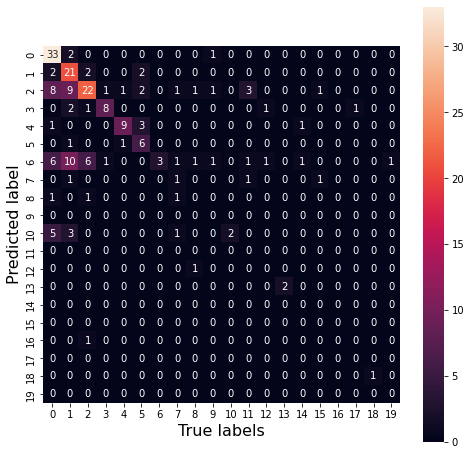

The accuracy is 0.5294117647058824


In [ ]:
# Code adapted from: https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a#:~:text=1.-,Introduction,is%20independent%20of%20each%20other.
# This part plots the confusion matrix on a heat map
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(Y_test_c, class_predict_c)

# Create heat map with seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True labels", fontdict={"fontsize": 16})
plt.ylabel("Predicted label", fontdict={"fontsize": 16})

# Show the map
plt.show()
print("The accuracy is {}".format(accuracy_score(Y_test_c, class_predict_c)))

#### Naive Bayes

###### Experiment 3: Naive Bayes with TFIDF

In [ ]:
# From tutorials, this part is to split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df_s['stem'], df_s['category_number'], random_state=30)

In [ ]:
# This part is to transform the training and testing data, using TFIDF
# Fit the training data and then return the matrix
training_data = vectorizer_tfidf.fit_transform(X_train)

# Transform testing data and return the matrix
testing_data = vectorizer_tfidf.transform(X_test)

In [ ]:
# This part is to train the naive bayes model on the training data
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

MultinomialNB()

In [ ]:
# This part is to get the predictions on the testing data made by the naive bayes model
predictions = naive_bayes.predict(testing_data)

In [ ]:
# This part evaluates the model with confusion matrix and accuracy score
print('Accuracy Score',accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy Score 0.531496062992126
[[107  16   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  6  96   2   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 19  16  36   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 16   5   2  13   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  9  10   2   0  16   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  2  12   8   2   3   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  3  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [ 12   7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  5   6   6   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  2   3   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0]
 [  2   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


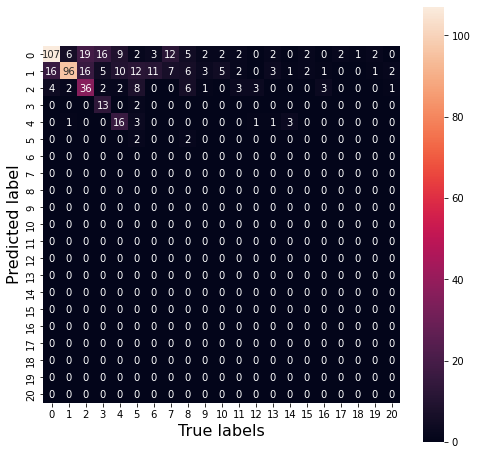

The accuracy is 0.531496062992126


In [ ]:
# Code adapted from: https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a#:~:text=1.-,Introduction,is%20independent%20of%20each%20other.
# This part plots the confusion matrix on a heat map
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, predictions)

# Create heat map with seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
#, xticklabels=x_axis_labels, yticklabels=y_axis_labels
plt.xlabel("True labels", fontdict={"fontsize": 16})
plt.ylabel("Predicted label", fontdict={"fontsize": 16})

# Show the map
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predictions)))

###### Experiment 4: Naive Bayes with Count Vectorizer

In [ ]:
# From tutorials, this part is to split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(df_s['stem'], df_s['category_number'], random_state=30)

In [ ]:
# This part is to transform the training and testing data, using count vectorizer
# Fit the training data and then return the matrix
training_data = vectorizer_count.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = vectorizer_count.transform(X_test)

In [ ]:
# This part is to train the naive bayes model on the training data
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data,y_train)

MultinomialNB()

In [ ]:
# This part is to get the predictions on the testing data made by the naive bayes model
predictions = naive_bayes.predict(testing_data)

In [ ]:
# This part evaluates the model with confusion matrix and accuracy score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
print('Accuracy Score',accuracy_score(y_test,predictions))
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

Accuracy Score 0.594488188976378
[[80 16  6  7  2  3  6  3  0  0  1  0  0  2  0  0  0  0  1  0  0]
 [ 2 81  4  3  3  2  4  4  0  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 7  4 41  3  5  1  5  0  0  3  0  0  0  0  0  0  2  0  0  0  0]
 [ 1  1  1 27  0  2  1  0  0  0  0  0  0  0  0  0  1  0  2  0  0]
 [ 0  1  0  0 23  3  2  1  1  0  1  2  0  0  2  1  0  0  0  0  0]
 [ 0  3  0  2  7 13  0  0  0  1  1  1  1  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  0  0  6  3  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  2  1  0  2  0  0  8  0  1  2  0  0  1  0  0  0  1  0  0  0]
 [ 0  1  2  0  0  3  4  1  5  1  0  0  1  1  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  1  0  0  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  1  0  4  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  1  1  0  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  1  0  1  0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


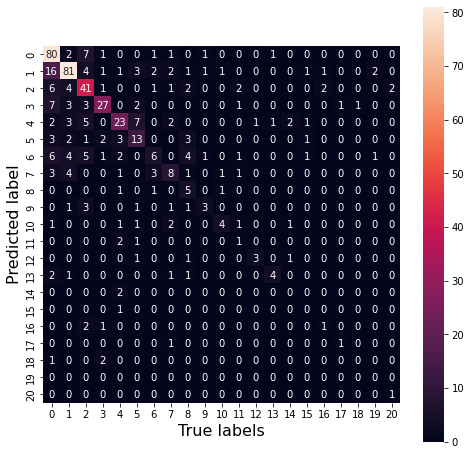

The accuracy is 0.594488188976378


In [ ]:
# Code adapted from: https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a#:~:text=1.-,Introduction,is%20independent%20of%20each%20other.
# This part plots the confusion matrix on a heat map
import seaborn as sns
import matplotlib.pyplot as plt
mat = confusion_matrix(y_test, predictions)

# Create heat map with seaborn
plt.figure(figsize=(8, 8))
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True labels", fontdict={"fontsize": 16})
plt.ylabel("Predicted label", fontdict={"fontsize": 16})

# Show the map
plt.show()
print("The accuracy is {}".format(accuracy_score(y_test, predictions)))

# Unsupervised Learning

###### Import Data

In [ ]:
# Reference: https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7
# import other required libs
import pandas as pd
import numpy as np

# string manipulation libs
import re
import nltk

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

# Remove transcripts with N/A
data_un = data.dropna(subset = ["transcript"])
data_un.reset_index(inplace = True, drop = True)
data_un["category"]

0       Earth/Environment/Ecosystem
1                        Technology
2                          Politics
3                        Technology
4                        Technology
                   ...             
2027                 Health/Science
2028                     Technology
2029    Emotions/Behaviour/Humanity
2030    Emotions/Behaviour/Humanity
2031                     Technology
Name: category, Length: 2032, dtype: object

#### Data Cleaning


In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

# Create an empty array
corpus = []

# Remove non-text characters and stop words, then add them into the array
for i in range(len(data_un)):
    curr = data_un['transcript'][i]
    review = re.sub('[^a-zA-Z]', ' ', curr)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    stop_words = stopwords.words('english')
    review = [ps.stem(word) for word in review if not word in set(stop_words) and word != 'people' and 
              word != 'like' and word != 'look' and word != 'think' and word != 'its' and word != 'really' and word != "one" and word != "two" and word != "go"]
    review = ' '.join(review)
    corpus.append(review)

#### Count Vectorizer & TFIDF

In [ ]:
# TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create Count Vectorizer
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(corpus).toarray()

# Create TFIDF Vectorizer
tv = TfidfVectorizer(max_features = 1000)
X_tv = tv.fit_transform(corpus).toarray()

#### KMeans & Elbow Method

###### Graph


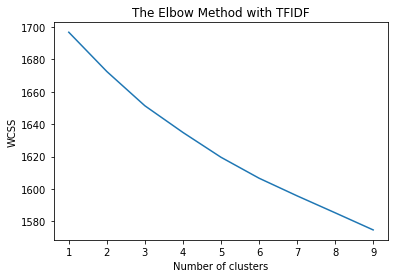

In [ ]:
#This section is to find the optimal number of clusters given TFIDF
from sklearn.cluster import KMeans

# Create an empty array for the sum of the squared distance between each member of the cluster and its centroid.
wcss = []

# User Elbow method to find the optimal number of clusters
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_tv)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method with TFIDF')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

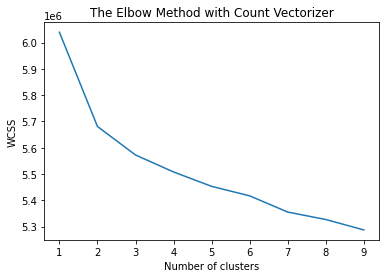

In [ ]:
#This section is to find the optimal number of clusters given Count Vectorizer
from sklearn.cluster import KMeans

# Create an empty array for the sum of the squared distance between each member of the cluster and its centroid.
wcss = []

# User Elbow method to find the optimal number of clusters
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method with Count Vectorizer')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

###### Set number of clusters for KMeans

In [ ]:
# Initialize kmeans with 3 centroids
# random_state helps to reproduce consistent results
kmeans = KMeans(n_clusters=3, random_state=30)

# Fit into the model
kmeans.fit(X)
clusters = kmeans.labels_

####  PCA


In [ ]:
# Reduce dataset dimensions, increase interpretability, and minimize information loss to best summarize the total variability of data
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# Pass X from count vectorizer into the PCA 
pca_vecs = pca.fit_transform(X)
# Store the 2 dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:
# Visualization

# Create dataframe 
dataset_df = pd.DataFrame()

# Store clusters, category, and PCA vectors to the dataframe
dataset_df["x0"] = x0 
dataset_df["x1"] = x1
dataset_df["cluster"] = clusters
dataset_df["category"] = data_un.category

In [ ]:
# This part is to show the top key words for each centroid from KMeans
def get_top_keywords(n_terms):
    # Group by clusters
    df = pd.DataFrame(X).groupby(clusters).mean() 
    # Get the terms
    terms = cv.get_feature_names_out() 
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(30)


Cluster 0
much,someth,also,call,start,first,right,need,take,well,come,say,laughter,could,actual,use,work,want,way,make,world,us,would,go,know,time,thing,year,get,see

Cluster 1
talk,littl,come,got,lot,could,start,us,kind,world,someth,well,use,right,said,actual,way,year,work,see,would,make,time,say,want,laughter,get,go,know,thing

Cluster 2
call,live,start,new,come,right,even,actual,also,need,first,take,could,applaus,way,go,world,want,work,laughter,would,know,get,thing,us,make,use,see,time,year


#### Clustering Results

###### Clusters from KMeans

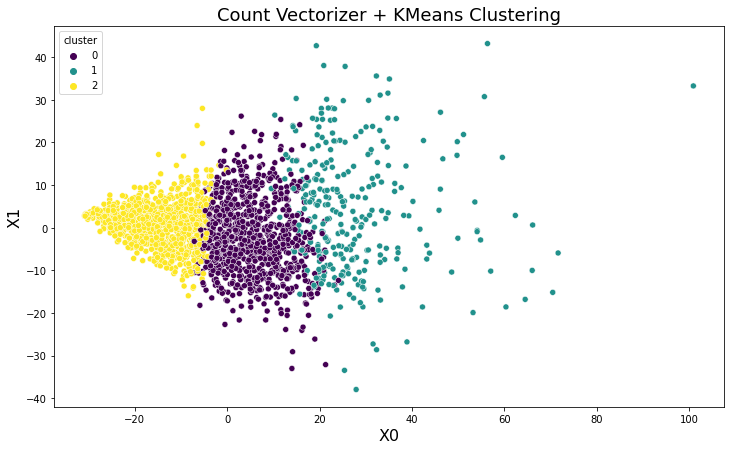

In [ ]:
# This shows the clusters baesd on KMeans
import seaborn as sns

# Figure size
plt.figure(figsize=(12, 7))
# Title
plt.title("Count Vectorizer + KMeans Clustering", fontdict={"fontsize": 18})
# x and y axes 
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# Create scatter plot with seaborn
# Set hue to the cluster to group data
sns.scatterplot(data=dataset_df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

###### By Categories

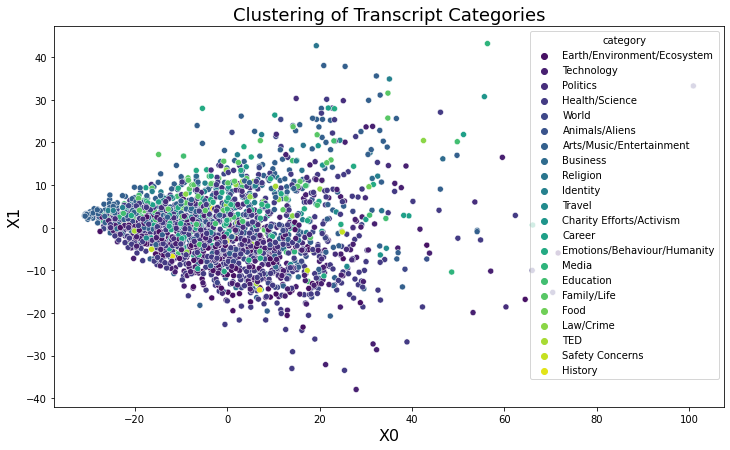

In [ ]:
# This shows the clusters of words used in the transcripts in each category
import seaborn as sns

# Figure size
plt.figure(figsize=(12, 7))
# Title
# Each point is a transcript and identify the category by color
plt.title("Clustering of Transcript Categories", fontdict={"fontsize": 18})
# x and y axes
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# Create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=dataset_df, x='x0', y='x1', hue='category', palette="viridis")
plt.show()